## Introduction

In this notebook we will try to use serval deep learning methods to make opinion mining on movie reviews. 


## Data Loading and  Exploratory Analysis

In [64]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
#read the data
data = pd.read_csv('D:\\Projects\\Opinion Mining\\imdb-dataset-of-50k-movie-reviews\\IMDB Dataset.csv')

In [65]:
#pick at the first 5 rows of the data
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [67]:
data.sentiment.value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [ ]:
#importing and installing of packages
!pip install stanza
import os,re,nltk,stanza
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

### Data Cleaning

In [ ]:
#for lets prepare all the functions and tools, in the end will apply them all in sequntioal order on the dataframe
def data_cleaning(rev:str)->str:
    """
    lower-casing, decontraction  and cleaning of html tags for each review

    Parameters
    ----------
    rev : str
        the review that needs to be preprocessed.

    Returns
    -------
    rev : str
        the cleaned review .

    """
    rev = re.sub(re.compile('<.*?>'), "", rev.lower())
    rev = re.sub("'s", " is", rev)
    rev = re.sub("'ve", " have", rev)
    rev = re.sub("n't", " not", rev)
    rev = re.sub("cannot", " can not", rev)
    rev = re.sub("'re", " are", rev)
    rev = re.sub("'d", " would", rev)
    rev = re.sub("'ll", " will", rev)
    rev = re.sub("won\'t", "will not", rev)
    rev = re.sub("can\'t", "can not", rev)
    rev = re.sub("\'t", " not", rev)
    rev = re.sub("\'ve", " have", rev)
    rev = re.sub("\'m", " am", rev)
    rev = re.sub("[^a-z ]+", '', rev.replace('.',' ').replace(',',' '))
    return rev

### Dim reduction cont.: Stop words Removal

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) - {'not', 'nor','no'}
def remove_bad_words(rev:str)->str:
    """
     stop words(except no,not and nor) and single character word removal
        
     Parameters
     ----------
     rev : str
         review to be cleaned.

     Returns
     -------
     rev : str
         review after the cleaning process.

     """
    temp=""
    for word in rev.split():
        if word not in stop_words and len(set(word))>1:
            temp+=word+ " "
    return temp

### Dim Reduction: Word Normalization

In [ ]:
stanza.download('en')
nlp = stanza.Pipeline(lang='en', processors="tokenize, mwt,pos,lemma",tokenize_no_ssplit=True)
def lematize(rev:str)->list:
    """
    lemattization of the review. 
        
    Parameters
    ----------
    rev : str
        the review that we want to lemmatize.

    Returns
    -------
    rev : list
        the review after tokenization and lematization.

    """
    return [ word.lemma for sent in nlp(rev).sentences for word in sent.words]

### Split the data into train-dev and test sets

In [ ]:
def split_into_train_test_dev():
    global data
    temp = {}
    temp['train'], temp['test'] = train_test_split(data, test_size=0.15, random_state=42)
    temp['train'] , temp['dev'] = train_test_split(temp['train'], test_size=0.15, random_state=42)
    data = temp

### Numerical-Encoding of the words

In [1]:
class Dictionary:
    """
    a class that represents the dictionary of the text
    the class gives a unique index to every word
    """
    def __init__(self):
        self.word2idx = {"PAD":0}
        self.idx2word = {0:"PAD"}
        self.word2freq = {"PAD":1}
        self.idx = 1
    
    def add_words(self,input):
        """
        Input: word or words 
        InputType: list,tuple or str
        a method to add a word(s),
        the method checks if the word(s) is allredy in the dictinoary
        if not, add it.
        othewith adds one to its freq
        """
        def add():
            if word not in self.word2idx.keys():
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.word2freq[word] = 1
                self.idx+=1
            else:
                self.word2freq[word] += 1
       
        def addSeq():
            nonlocal word
            for word in input:
                add()
        inputType = type(input)
        word = []
        if inputType != list and inputType != str and inputType != tuple:
            raise TypeError ("dict at add_word :the type of the input is not allowed")
        if inputType == "str":
            input = [input]
        addSeq()
            
            
    def __getitem__(self,words):
        try:
            if type(words) == str:
                return self.word2idx[words]
            return [self.word2idx[word] for word in words]

        except KeyError:
            print("The word does not exists in the dict")
            return None
    
    def __setitem__(self,word,id):
        """
        add (word,id) to the dict iff the word does not appear in the dict
        """
        if word not in self.word2idx.keys():
            self.word2idx[word] = id 
            self.word2idx[id] = word 
            self.idx+=1

            
    def __len__(self):
        """
        returns the size of the dictionary
        """
        return len(self.word2idx)

In [ ]:
dictionary =Dictionary()
def fit_on_train(rev:list)->list:
    """
    building dictionary based on the words in the train set
    the final result of this method is a dictionary that holds 
    the following information:
    for each word:
        1. it's uniqe id (for future translation of the words in case of embedding layer)
        2. the freq of each word in the set (for optional filtering of un-freqent words)
 

    Parameters
    ----------
    rev : list
        list of words.

    Returns
    -------
    rev : list
        list of words.

    """
    dictionary.add_words(rev)
    return rev

In [ ]:
def transform(rev:list)->list:
    """
    function to transform a review into sequence 

    Parameters
    ----------
    rev : list
        list of tokens.
 
    Returns
    -------
    list
        returns the transformed review.

    """
    return [dictionary[word] for word in rev if dictionary[word]]

### Building weight-matrix based on FastText vectors

In [ ]:
def build_weight_matrix():
    """
    a function that creates weight_matrix out of FastText pre-trained vectors
    for future use as a weights init of an embedding layer
    if there is no vector for the word that we inizlize it with random vector
        
    Returns
    -------
    weight_matrix : list
    """
    def init_fast_text():
        nonlocal fastText,dim
        print("Loading FastText pre-trained vectors")
        with open('D:\\Projects\\Opinion Mining\\fasttext-wikinews\\wiki-news-300d-1M.vec', 'r', encoding='utf-8', newline='\n',errors='ignore') as f:
            _, dim = map(int, f.readline().split())
            fastText = {}
            for line in f:
                tokens = line.rstrip().split(' ')
                fastText[tokens[0]] = np.asarray(tokens[1:], "float32")
    
    def build_matrix():
        nonlocal weights_matrix
        print("starting to build weight matrix for embedding encoding,  based on FastText pre-trained vectors")
        maching_words = 0
        dataset_size = len(dictionary)+1
        weights_matrix = np.zeros(shape=(dataset_size,dim))
        for i,word in enumerate(dictionary.word2idx.keys(),1):
            try:
                save = fastText[word]
                maching_words += 1
            except KeyError:
                save = np.random.uniform(size=(dim,))
            weights_matrix[i] = save
                     
        print("pre-treind words: {} randomaly initilaized: {}".format(maching_words,dataset_size))     
    fastText,dim,weights_matrix=[],0,[]
    init_fast_text()
    build_matrix()
    data['matrix'] = weights_matrix

In [ ]:
data.review = data.review.apply(data_cleaning)
data.review = data.review.apply(remove_bad_words)
data.review = data.review.apply(lematize)
data.sentiment = data.sentiment.map(lambda sent:{'positive':1,'negative':0}[sent])
split_into_train_test_dev()
data["train"].review.apply(fit_on_train)
max_len = data["train"].review.apply(len).max()
for set in ["train","test","dev"]:     
    data[set].review = data[set].review.apply(transform)
    data[set].review = data[set].review.apply(lambda rev:rev+[0]
                                                      *(max_len-len(rev)) 
                                   if len(rev)<max_len else rev[:max_len])
    data[set] ={"X":np.array(data[set].review.to_list()),"Y":np.array(data[set].sentiment.to_list())}   

In [ ]:
build_weight_matrix()

In [ ]:
#for future use of the preprocessed data , so we will not do the preprocess again and agin on the draft , saving!
import pickle
data['dict'] = dictionary
with open("D:\\Projects\\Opinion Mining\\working\\data.pkl","wb") as f:
     pickle.dump(data,f)

In [2]:
#load the  trained data from the last draft session
import pickle
with open('D:\\Projects\\Opinion Mining\\pretrained-data-from-previous-draft-session\\data.pkl',"rb") as f:
     data = pickle.load(f)

## Problem defintion and Modeling

### Model 1: Baseline

In [17]:
#importing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Flatten 
from tensorflow.keras.callbacks import ModelCheckpoint
#callback: we will monitor val_acc (because it is a classification problem) and save the best model.
def checkpoint(name:str):
    return ModelCheckpoint(name, monitor='val_binary_accuracy', verbose=1, save_best_only=True,
                                   save_weights_only=False, mode='auto', save_freq="epoch")

In [18]:
#baseline
model = Sequential([Embedding(len(data['dict'])+1, 300,weights=[data['matrix']],input_length=data['train']['X'].shape[-1],
                              mask_zero=True,name="words_latent_space"),
                    Flatten(name="flat"),
                    Dense(1, activation='sigmoid',name='classifyer')],name="Baseline")

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])
model.summary()
hist = model.fit(data['train']['X'], data['train']['Y'], batch_size=64, epochs=8,
                                  validation_data=(data['dev']['X'],data['dev']['Y']),
                 callbacks=[checkpoint('/kaggle/working/fc_baseline.h5')])

Model: "Baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words_latent_space (Embeddin (None, 1147, 300)         31601100  
_________________________________________________________________
flat (Flatten)               (None, 344100)            0         
_________________________________________________________________
classifyer (Dense)           (None, 1)                 344101    
Total params: 31,945,201
Trainable params: 31,945,201
Non-trainable params: 0
_________________________________________________________________
Train on 36125 samples, validate on 6375 samples
Epoch 1/8
36096/36125 [============================>.] - ETA: 0s - loss: 0.5593 - binary_accuracy: 0.7398
Epoch 00001: val_binary_accuracy improved from -inf to 0.85286, saving model to /kaggle/working/fc_baseline.h5
36125/36125 [==============================] - 283s 8ms/sample - loss: 0.5589 - binary_accuracy: 0.7400 - val_

In [19]:
#configure ploting function for future use
import matplotlib.pyplot as plt
def plot(hist:dict,y_title:str,plot_title:str):
    plt.figure(figsize=(6,2),dpi=140,facecolor="w")
    plt.grid(c='black',linestyle="-",linewidth=2)
    plt.ylabel(y_title)
    plt.xlabel("epochs")
    plt.title(plot_title)
    plt.plot(hist)

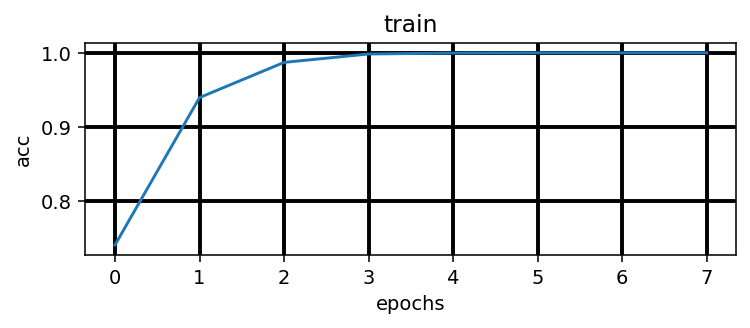

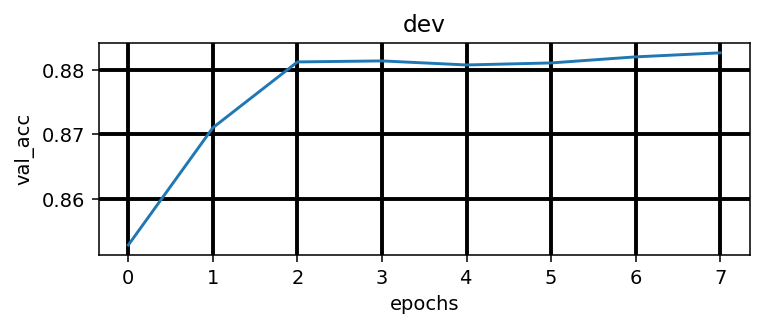

In [20]:
plot(hist.history["binary_accuracy"],"acc","train");plot(hist.history["val_binary_accuracy"],"val_acc","dev")

### Model 2: fc Embeddings

In [29]:
model = Sequential([Embedding(len(data['dict'])+1,200,input_length=data['train']['X'].shape[-1],
                              mask_zero=True,name="words_latent_space"),
                    Flatten(name="flat"),
                    Dense(1, activation='sigmoid',name='classifyer')],name="200_emd")

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])
model.summary()
hist = model.fit(data['train']['X'], data['train']['Y'], batch_size=64, epochs=8,
                                  validation_data=(data['dev']['X'],data['dev']['Y']),
                 callbacks=[checkpoint('/kaggle/working/fc_baseline_200_emd.h5')])

Model: "200_emd"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words_latent_space (Embeddin (None, 1147, 200)         21067400  
_________________________________________________________________
flat (Flatten)               (None, 229400)            0         
_________________________________________________________________
classifyer (Dense)           (None, 1)                 229401    
Total params: 21,296,801
Trainable params: 21,296,801
Non-trainable params: 0
_________________________________________________________________
Train on 36125 samples, validate on 6375 samples
Epoch 1/8
36096/36125 [============================>.] - ETA: 0s - loss: 0.3776 - binary_accuracy: 0.8231
Epoch 00001: val_binary_accuracy improved from -inf to 0.88816, saving model to /kaggle/working/fc_baseline_200_emd.h5
36125/36125 [==============================] - 187s 5ms/sample - loss: 0.3774 - binary_accuracy: 0.8232

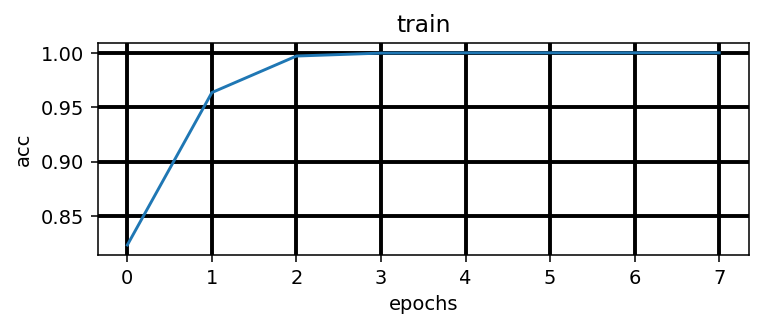

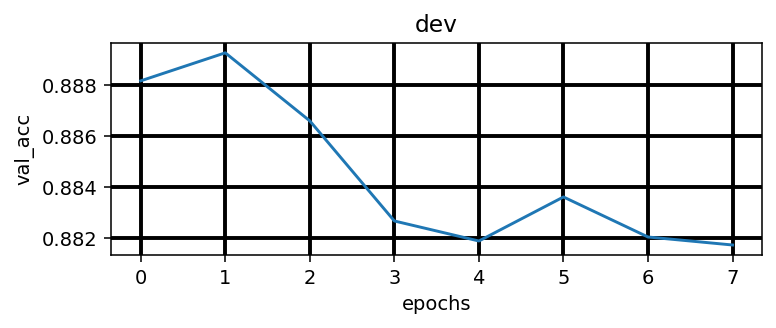

In [30]:
plot(hist.history["binary_accuracy"],"acc","train");plot(hist.history["val_binary_accuracy"],"val_acc","dev")

### Adding L2 regularization on the embeddings weights

In [34]:
from tensorflow.keras import regularizers

model = Sequential([Embedding(len(data['dict'])+1,200,input_length=data['train']['X'].shape[-1],
                              embeddings_regularizer=regularizers.l2(1e-6),
                              mask_zero=True,name="words_latent_space"),
                    Flatten(name="flat"),
                    Dense(1, activation='sigmoid',name='classifyer')],name="200_emb_d")

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])
model.summary()
hist = model.fit(data['train']['X'], data['train']['Y'], batch_size=64, epochs=5,
                                  validation_data=(data['dev']['X'],data['dev']['Y']),
                 callbacks=[checkpoint('/kaggle/working/fc_baseline_200_emb_r.h5')])

Model: "200_emb_d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words_latent_space (Embeddin (None, 1147, 200)         21067400  
_________________________________________________________________
flat (Flatten)               (None, 229400)            0         
_________________________________________________________________
classifyer (Dense)           (None, 1)                 229401    
Total params: 21,296,801
Trainable params: 21,296,801
Non-trainable params: 0
_________________________________________________________________
Train on 36125 samples, validate on 6375 samples
Epoch 1/5


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


36096/36125 [============================>.] - ETA: 0s - loss: 0.3919 - binary_accuracy: 0.8274
Epoch 00001: val_binary_accuracy improved from -inf to 0.88549, saving model to /kaggle/working/fc_baseline_200_emb_r.h5
36125/36125 [==============================] - 108s 3ms/sample - loss: 0.3918 - binary_accuracy: 0.8274 - val_loss: 0.2927 - val_binary_accuracy: 0.8855
Epoch 2/5
36096/36125 [============================>.] - ETA: 0s - loss: 0.1273 - binary_accuracy: 0.9627
Epoch 00002: val_binary_accuracy improved from 0.88549 to 0.88675, saving model to /kaggle/working/fc_baseline_200_emb_r.h5
36125/36125 [==============================] - 107s 3ms/sample - loss: 0.1273 - binary_accuracy: 0.9627 - val_loss: 0.3097 - val_binary_accuracy: 0.8867
Epoch 3/5
36096/36125 [============================>.] - ETA: 0s - loss: 0.0364 - binary_accuracy: 0.9966
Epoch 00003: val_binary_accuracy did not improve from 0.88675
36125/36125 [==============================] - 106s 3ms/sample - loss: 0.0364 -

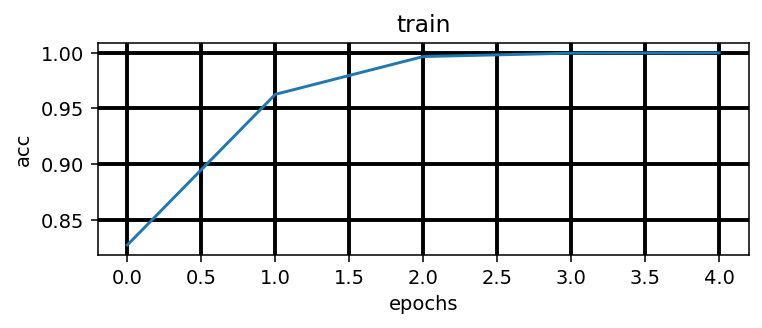

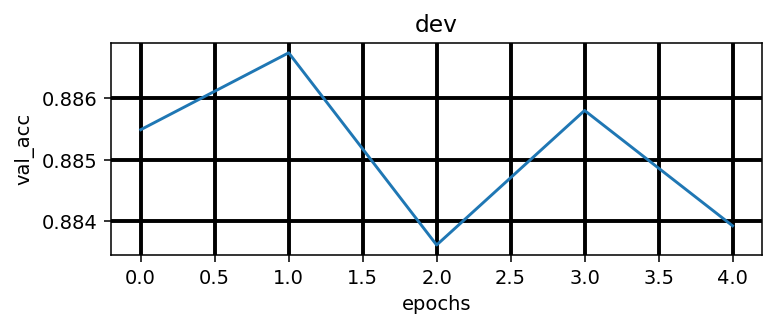

In [35]:
plot(hist.history["binary_accuracy"],"acc","train");plot(hist.history["val_binary_accuracy"],"val_acc","dev")

In [36]:
model = Sequential([Embedding(len(data['dict'])+1,128,input_length=data['train']['X'].shape[-1],
                              embeddings_regularizer=regularizers.l2(1e-6),
                              mask_zero=True,name="words_latent_space"),
                    Flatten(name="flat"),
                    Dense(1, activation='sigmoid',name='classifyer')],name="128_emd")

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])
model.summary()
hist = model.fit(data['train']['X'], data['train']['Y'], batch_size=64, epochs=5,
                                  validation_data=(data['dev']['X'],data['dev']['Y']),
                 callbacks=[checkpoint('/kaggle/working/128_emd.h5')])

Model: "128_emd"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words_latent_space (Embeddin (None, 1147, 128)         13483136  
_________________________________________________________________
flat (Flatten)               (None, 146816)            0         
_________________________________________________________________
classifyer (Dense)           (None, 1)                 146817    
Total params: 13,629,953
Trainable params: 13,629,953
Non-trainable params: 0
_________________________________________________________________
Train on 36125 samples, validate on 6375 samples
Epoch 1/5


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


36096/36125 [============================>.] - ETA: 0s - loss: 0.3884 - binary_accuracy: 0.8229
Epoch 00001: val_binary_accuracy improved from -inf to 0.88878, saving model to /kaggle/working/128_emd.h5
36125/36125 [==============================] - 51s 1ms/sample - loss: 0.3884 - binary_accuracy: 0.8230 - val_loss: 0.2842 - val_binary_accuracy: 0.8888
Epoch 2/5
36096/36125 [============================>.] - ETA: 0s - loss: 0.1432 - binary_accuracy: 0.9541
Epoch 00002: val_binary_accuracy did not improve from 0.88878
36125/36125 [==============================] - 50s 1ms/sample - loss: 0.1433 - binary_accuracy: 0.9540 - val_loss: 0.3001 - val_binary_accuracy: 0.8872
Epoch 3/5
36096/36125 [============================>.] - ETA: 0s - loss: 0.0466 - binary_accuracy: 0.9935
Epoch 00003: val_binary_accuracy did not improve from 0.88878
36125/36125 [==============================] - 50s 1ms/sample - loss: 0.0466 - binary_accuracy: 0.9935 - val_loss: 0.3361 - val_binary_accuracy: 0.8842
Epoch

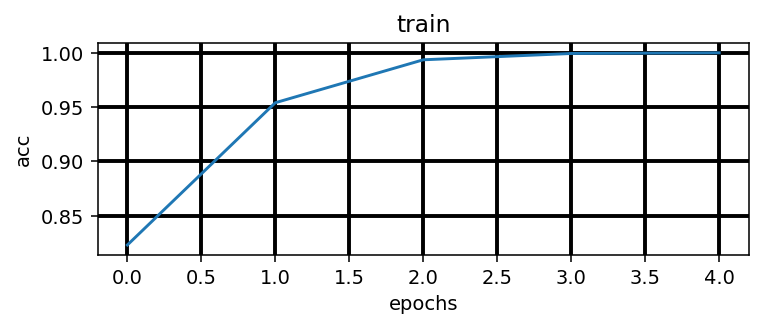

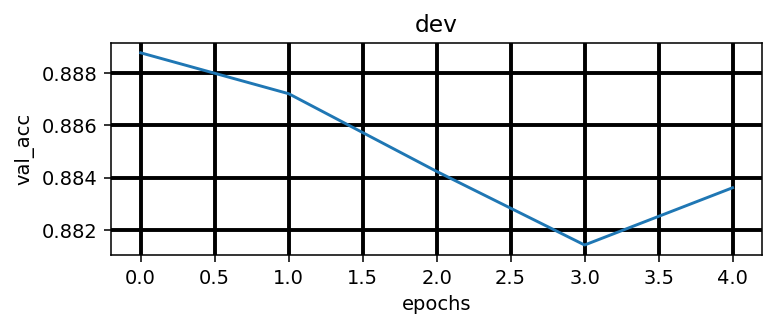

In [37]:
plot(hist.history["binary_accuracy"],"acc","train");plot(hist.history["val_binary_accuracy"],"val_acc","dev")

## LSTMS

In [38]:
#baseline
from tensorflow.keras.layers import Bidirectional,LSTM
model = Sequential([Embedding(len(data['dict'])+1, 300,weights=[data['matrix']], mask_zero=True),
                    Bidirectional(LSTM(300),name="bi-lstm"),
                    Dense(1, activation='sigmoid',name='classifyer')],name="lstm_base")

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])
model.summary()
hist = model.fit(data['train']['X'], data['train']['Y'], batch_size=64, epochs=5,
                                  validation_data=(data['dev']['X'],data['dev']['Y']),
                 callbacks=[checkpoint('/kaggle/working/lstm_base.h5')])

Model: "lstm_base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 300)         31601100  
_________________________________________________________________
bi-lstm (Bidirectional)      (None, 600)               1442400   
_________________________________________________________________
classifyer (Dense)           (None, 1)                 601       
Total params: 33,044,101
Trainable params: 33,044,101
Non-trainable params: 0
_________________________________________________________________
Train on 36125 samples, validate on 6375 samples
Epoch 1/5
36096/36125 [============================>.] - ETA: 0s - loss: 0.4018 - binary_accuracy: 0.8136
Epoch 00001: val_binary_accuracy improved from -inf to 0.87843, saving model to /kaggle/working/lstm_base.h5
36125/36125 [==============================] - 339s 9ms/sample - loss: 0.4017 - binary_accuracy: 0.8136 - val_l

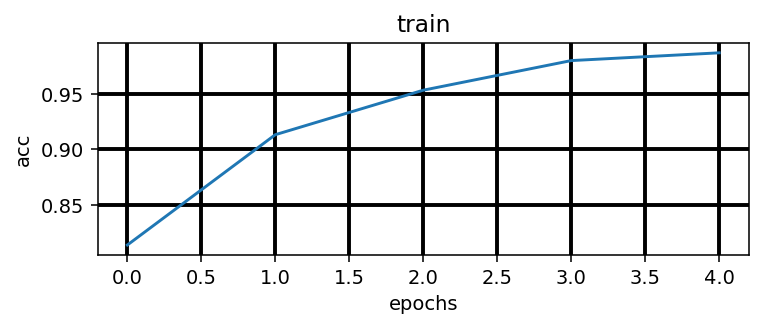

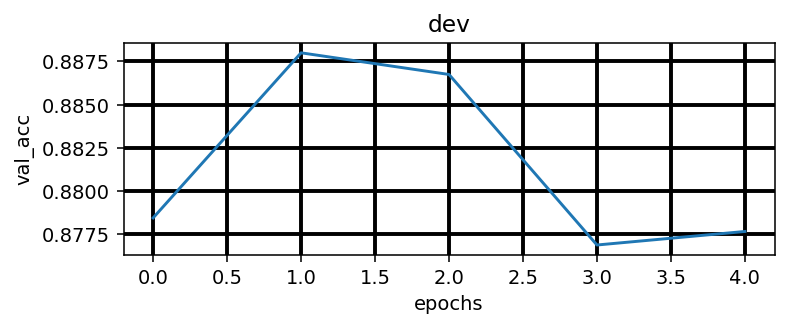

In [39]:
plot(hist.history["binary_accuracy"],"acc","train");plot(hist.history["val_binary_accuracy"],"val_acc","dev")

### Model: less cells

In [53]:
model = Sequential([Embedding(len(data['dict'])+1, 128,mask_zero=True),
                    Bidirectional(LSTM(128),name="bi-lstm"),
                    Dense(1, activation='sigmoid',name='classifyer')],name="lstm_128")

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])
model.summary()
hist = model.fit(data['train']['X'], data['train']['Y'], batch_size=64, epochs=5,
                                  validation_data=(data['dev']['X'],data['dev']['Y']),
                 callbacks=[checkpoint('/kaggle/working/lstm_128.h5')])

Model: "lstm_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 128)         13483136  
_________________________________________________________________
bi-lstm (Bidirectional)      (None, 256)               263168    
_________________________________________________________________
classifyer (Dense)           (None, 1)                 257       
Total params: 13,746,561
Trainable params: 13,746,561
Non-trainable params: 0
_________________________________________________________________
Train on 36125 samples, validate on 6375 samples
Epoch 1/5
36096/36125 [============================>.] - ETA: 0s - loss: 0.3353 - binary_accuracy: 0.8537
Epoch 00001: val_binary_accuracy improved from -inf to 0.89004, saving model to /kaggle/working/lstm_128.h5
36125/36125 [==============================] - 145s 4ms/sample - loss: 0.3352 - binary_accuracy: 0.8538 - val_los

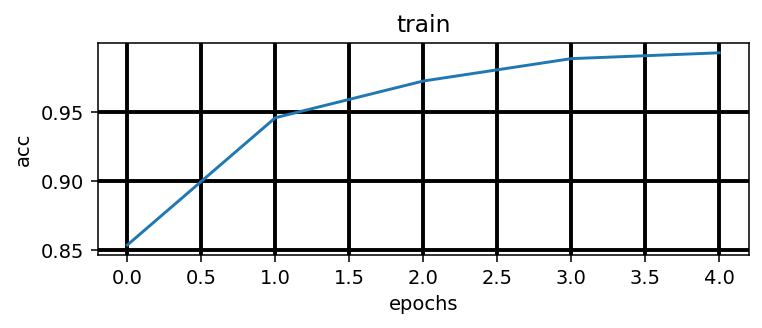

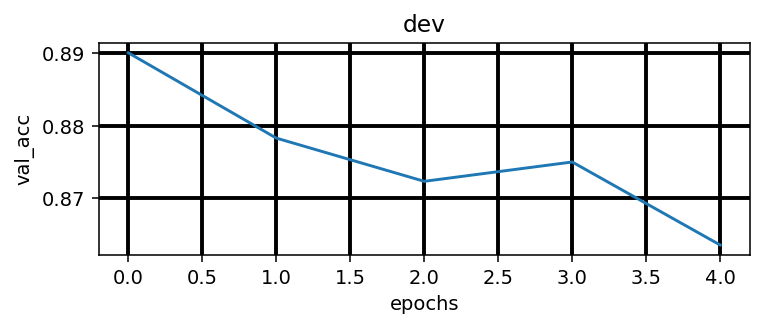

In [54]:
plot(hist.history["binary_accuracy"],"acc","train");plot(hist.history["val_binary_accuracy"],"val_acc","dev")

### TEST

In [55]:
from tensorflow.keras.models import load_model
best_model= load_model('/kaggle/working/lstm_128.h5')
eval=best_model.predict_classes(data['test']['X'])
from sklearn.metrics import classification_report
print(classification_report(eval, data['test']['Y']))                        

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      3657
           1       0.91      0.89      0.90      3843

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.90      7500
weighted avg       0.90      0.90      0.90      7500

